# Retina tuning curves

author: laquitainesteeve@gmail.com based on codes from Carlo Paris

## Setup 


activate fisher_info_limits2

```python
python -m ipykernel install --user --name fisher_info_limits2 --display-name "fisher_info_limits2"
```

In [1]:
# import packages
import os
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle5 as pickle
from scipy.stats import spearmanr, wilcoxon
from matplotlib.gridspec import GridSpec as GS
import math

# setup project path
proj_path = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(proj_path)

# import custom package
import ssiProjectModule as ssiMod

# setup tuning curves parameters
sample_size = 500
theta_step = 2

# setup data paths
dat_dir_in = os.path.join(proj_path, 'data/decoding_analysis/')
data_dir = 'data/bayer_decoding_error/'+f'Bayes_Dec_Errs_{sample_size}reps_thetastep{theta_step}'+'.npz'
title = f'Stretch_BioQuads_multiplied_w_mean_g__theta_step={theta_step}_original_g_20240509_AREA.pkl'

# setup indices of examples of retina tuning curves quads
chosen_quads = np.array([201, 125, 104, 491])

# setup plot parameters
labelsize = 25
legend_fontsize = 15
text_size = 30
tick_labelsize = 20
letter_size=40
plt.rcParams['xtick.labelsize']=tick_labelsize
plt.rcParams['ytick.labelsize']=tick_labelsize
mpl.rcParams['axes.spines.right']=False

## Functions

In [ ]:
# neural encoder -------------------------------------------------------

def get_tuning_curves_pms(data:dict, n_neurons=4, example_quad_ix=0, width_ix=34, chosen_quads=np.array([201, 125, 104, 491])):
    """get the parameters for each neuron of the specified example quad
    
    Args:
        n_neurons = 4
        example_ix = 0  # example of quad of tuning curves selected
        width_ix = 34   # index of the tuning curve width we work with
    """
    prms = dict()
    for neuron_ix in range(n_neurons):
        exple_quad = data['all_quad_pars'][chosen_quads[example_quad_ix], width_ix]           # example quad
        area, pref_dir, width, baseline, flatness = exple_quad[neuron_ix] # tuning curves parameters
        prms[neuron_ix] = {'area': area, 'pref_dir': pref_dir, 'width': width, 'baseline': baseline, 'flatness': flatness}
    return prms


def get_tuning_curves_pms_in_rads(data:dict, n_neurons=4, example_quad_ix=0, width_ix=34, chosen_quads=np.array([201, 125, 104, 491])):
    """get the parameters for each neuron of the specified example quad
    
    Args:
        n_neurons = 4
        example_ix = 0  # example of quad of tuning curves selected
        width_ix = 34   # index of the tuning curve width we work with
    """
    prms = dict()
    for neuron_ix in range(n_neurons):

        # get tuning parameters
        exple_quad = data['all_quad_pars'][chosen_quads[example_quad_ix], width_ix]     # example quad
        area, pref_dir, width, baseline, flatness = exple_quad[neuron_ix]              # tuning curves parameters
         
        # convert to radians
        pref_dir = np.deg2rad(pref_dir)
        flatness = np.deg2rad(flatness)

        # store parameters
        prms[neuron_ix] = {'area': area, 'pref_dir': pref_dir, 'width': width, 'baseline': baseline, 'flatness': flatness}
    return prms


def get_flat_topped_von_mises_in_deg(x, area, pref_dir, width, baseline, flatness):
    '''Modified Von Mises function\n Parameters Area, mean, concentration, baseline, flatness\n g = 0 gives Von Mises function'''
    
    x = x.flatten()

    ftvm_f = np.exp(np.float64((np.cos(np.deg2rad(x-pref_dir-flatness*np.sin(np.deg2rad(x-pref_dir))))-1)/width))
    res = (area*ftvm_f / np.sum(ftvm_f/(len(x)/36)) + baseline) 
    return res+np.any(res<0.)*1e10


def get_flat_topped_von_mises(x, area, pref_dir, width, baseline, flatness):
    '''Modified Von Mises function
    Args: 
        x: in radians
        pref_dir: in radians
        Area, mean, concentration, baseline, flatness
        g = 0 gives Von Mises function
    '''
    x = x.flatten()
    ftvm_f = np.exp(
        np.float64(
            (np.cos(                
                x - pref_dir - flatness * np.sin( x - pref_dir)
                )-1)/width
            )
        )
    res = (area*ftvm_f / np.sum(ftvm_f/(len(x)/36)) + baseline) 
    return res+np.any(res<0.)*1e10


def tuning_curve_deg(x, prms: dict):
    """get tuning curves for many neurons
    with a parameter set per neuron

    Args:
        x (_type_): as degrees
        prms (dict): _description_

    Returns:
        _type_: _description_
    """
    tuning_curves = []
    for ix, _ in enumerate(prms):
        tuning_curves.append(get_flat_topped_von_mises_in_deg(x, **prms[ix]))
    return np.array(tuning_curves)


def tuning_curve(x, prms: dict):
    """get tuning curves for many neurons
    with a parameter set per neuron

    Args:
        x (np.array): in radians
        prms (dict): with keys=
        - "pref_dir" in radians
        - "flatness" in radians

    Returns:
        _type_: _description_
    """
    x = x.flatten()
    
    tuning_curves = []
    for neuron_ix, _ in enumerate(prms):
        
        # store tuning curves
        tuning_curves.append(get_flat_topped_von_mises(x, **prms[neuron_ix]).squeeze())
    return np.array(tuning_curves)

## Neural encoder

CPU times: user 28.5 ms, sys: 98.1 ms, total: 127 ms
Wall time: 126 ms


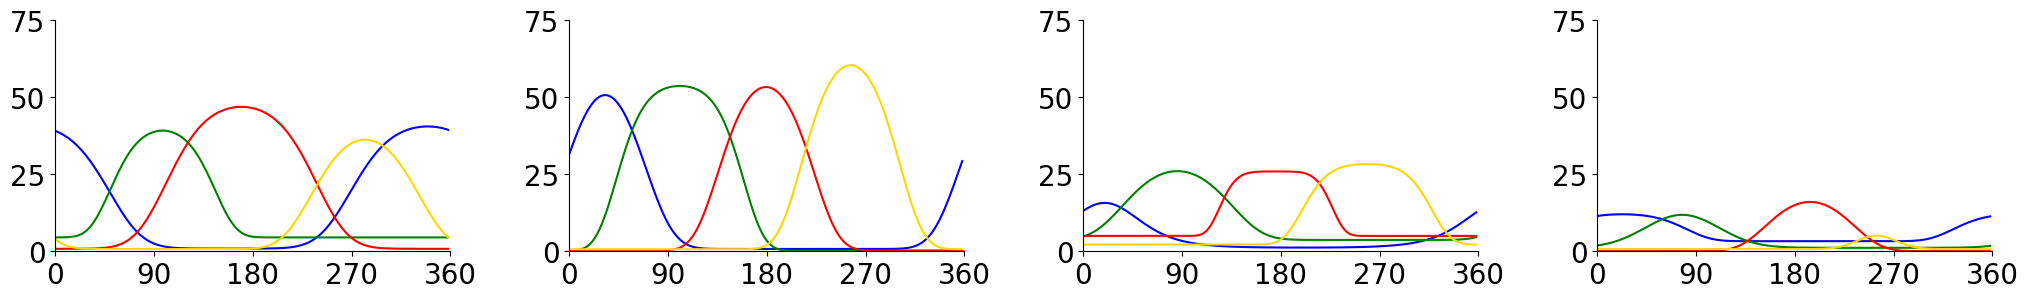

In [3]:
%%time 

# setup stimulus direction space in degrees
stim = np.arange(0, 360, theta_step)

# load tuning curves data
with open(dat_dir_in + title, 'rb') as rick:
    data_dict = pickle.load(rick)
bio_idx = np.where(data_dict['all_multipliers']==1.)[0][0]

# get four examples of tuning curves quad of shape (n_neurons, n_directions)
tuning_curve_data_1 = data_dict['all_quad_tc'][chosen_quads[0], bio_idx]
tuning_curve_data_2 = data_dict['all_quad_tc'][chosen_quads[1], bio_idx]
tuning_curve_data_3 = data_dict['all_quad_tc'][chosen_quads[2], bio_idx]
tuning_curve_data_4 = data_dict['all_quad_tc'][chosen_quads[3], bio_idx]

# bundle tuning curves in a list
all_tuning_curves = [tuning_curve_data_1, tuning_curve_data_2, tuning_curve_data_3, tuning_curve_data_4]

# setup plot
fig = plt.figure(figsize=(25,3))
gs = GS(1, 4, wspace=0.3, hspace=0.75)
colors = ['blue', 'green', 'red', 'gold']

# plot tuning curves
for i, quad in enumerate(all_tuning_curves):

    ax = fig.add_subplot(gs[0,i])
    for j, tuning_curve_data in enumerate(quad):
        ax.plot(stim, tuning_curve_data/1.6, color = colors[j])

    # formatting
    ax.set_xlim(0,360)
    ax.set_ylim(0,75)    
    ax.set_xticks(np.arange(0,361, 90))
    ax.set_yticks(np.arange(0,76, 25))

## Replicate with functions

In [4]:
# 648 quad of RGCs, each quad has 4 cells 
# find the unique lines
print(data_dict.keys())
# np.where(data_dict['all_multipliers']==1)[0] # 34 (the width we focus on. The biological cell width)
print(data_dict['all_quad_pars'].shape)
print(data_dict['all_quad_pars'][:,34][0,:]) # 4 cells each, has 5 parameters for the flat tuning curve (area, preferred direction, width, baseline, flatness)

# data_dict['all_quad_pars'][:,34][0,:].shape
print(data_dict['all_quad_pars'][201,34]) # 4 cells x 5 parameters for the first quad of RGCs
print(data_dict['all_quad_pars'][215,34]) # 4 cells x 5 parameters for the second quad of RGCs
print(data_dict['all_quad_pars'][104,34]) # 4 cells x 5 parameters for the third quad of RGCs
print(data_dict['all_quad_pars'][491,34]) # 4 cells x 5 parameters for the fourth quad of RGCs

dict_keys(['all_multipliers', 'all_quad_pars', 'all_quad_tc', 'all_ssis', 'all_quad_fwhm'])
(648, 56, 4, 5)
[[ 5.40625952e+02 -5.43997798e+00  3.16961095e-01  2.70261244e+00
   4.65610902e+01]
 [ 3.56959681e+02  8.58656662e+01  1.34182514e-01  5.89973110e+00
   3.24828084e+01]
 [ 4.60588743e+02  1.70400479e+02  4.79436346e-02  1.50517016e+01
   4.87312403e+01]
 [ 2.22335766e+02 -9.64286512e+01  3.58006067e-01  2.35733984e+00
  -7.46146928e+00]]
[[ 8.58060007e+02 -2.06559820e+01  2.37367421e-01  1.36833315e+00
   3.74564562e+01]
 [ 4.95056711e+02  9.79983531e+01  4.28942145e-02  7.20564692e+00
   4.40413013e+01]
 [ 9.66955762e+02  1.69688390e+02  2.14032799e-01  1.27317324e+00
   3.77344552e+01]
 [ 5.56806619e+02 -7.75902264e+01  1.22574361e-01  1.16092725e+00
   3.32107253e+01]]
[[ 2.39603981e+02  3.70390876e+01  3.67978110e-02  2.02111637e-01
   3.80074695e+01]
 [ 3.09243758e+02  8.27616708e+01  9.29113531e-03  8.60728952e-01
   4.82176910e+01]
 [ 3.85684049e+02 -1.49606613e+02  1.981

### Degrees

(4, 180)


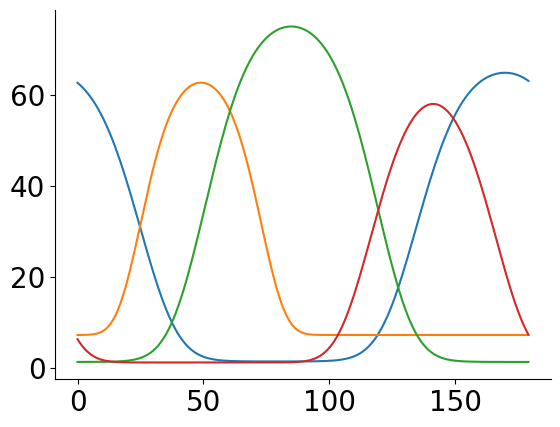

In [7]:
# setup stimulus direction space in degrees
stim = np.arange(0, 360, theta_step)

# get tuning curve parameters in degrees
prms = get_tuning_curves_pms(data_dict, example_quad_ix=0)

# get tuning curves
rates = tuning_curve_deg(stim, prms)
plt.plot(rates.T)
print(rates.shape)

### Radians

(4, 1256)


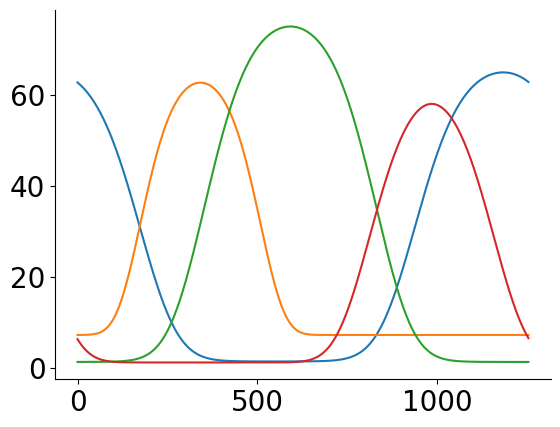

In [8]:
# setup stimulus in radians
dx = 0.005
x = np.arange(0,2*pi,dx)
x = x[:-1][None]

# get tuning curve parameters in radians
prms = get_tuning_curves_pms_in_rads(data_dict, example_quad_ix=0)

# get tuning curves
rates = tuning_curve(x, prms)

# plot
plt.plot(rates.T)
print(rates.shape)